In [1]:
import gzip
# Import dependences
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, f1_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR
from dmba import AIC_score, adjusted_r2_score, BIC_score, stepwise_selection
import math
import operator
from prettytable import PrettyTable
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
with gzip.open('compensation_cpi.csv.gz', 'rb') as f:
    df = pd.read_csv(f)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466589 entries, 0 to 1466588
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   year                1466589 non-null  int64  
 1   department          1466587 non-null  object 
 2   job_title           1466043 non-null  object 
 3   base_salary         1465890 non-null  float64
 4   overtime            1433207 non-null  float64
 5   irregular_cash      1466155 non-null  float64
 6   total_cash          1466589 non-null  float64
 7   retirement          1466589 non-null  float64
 8   health              1447602 non-null  float64
 9   other_benefits      830557 non-null   float64
 10  total_benefits      1466589 non-null  float64
 11  total_compensation  1466589 non-null  float64
 12  city_id             1466589 non-null  int64  
 13  annual_average_cpi  1466589 non-null  float64
 14  inflation_rate      1466589 non-null  float64
dtypes: float64(11),

In [4]:
df.head(3)

,year,department,job_title,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
0,2020,Recreation And Park Commission,Camp Assistant,5257.50,0.0,139.32,5396.82,0.0,0.0,418.88,418.88,5815.70,2,258.8,1.2
1,2020,Registrar,Junior Clerk,7699.19,1916.9,0.00,9616.09,0.0,0.0,746.36,746.36,10362.45,2,258.8,1.2
2,2020,Registrar,Junior Clerk,2619.15,930.5,0.00,3549.65,0.0,0.0,275.51,275.51,3825.16,2,258.8,1.2


In [5]:
df[df['department'].str.contains('District') == True]['department'].unique()

array(['District Attorney', 'DAT District Attorney',
       'Council - District 7', 'Council - District 2',
       'Council - District 10', 'Council - District 8',
       'Council - District 3', 'Council - District 5',
       'Council - District 1', 'Council - District 9',
       'Council - District 4', 'Council - District 6', 'Parks District 8'],
      dtype=object)

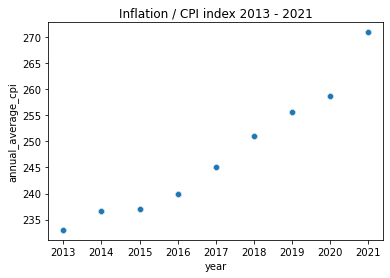

In [6]:
sns.scatterplot(data=df,x='year',y="annual_average_cpi")
plt.title("Inflation / CPI index 2013 - 2021");

In [7]:
#we have two missing department names but they are both police
df[df['department'].isna()]

,year,department,job_title,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
139761,2017,NaN,Sheriff's Cadet,49630.50,15016.51,3197.52,67844.53,10619.27,12779.88,4796.56,28195.71,96040.24,2,245.1,2.1
430579,2017,NaN,Police Officer 2,116189.62,40990.09,2260.08,159439.80,20076.66,14515.01,2724.05,37315.72,196755.52,2,245.1,2.1


In [8]:
#fill in the missing police department names
df['department'].fillna('Police',inplace=True)

In [9]:
df['department'].value_counts()

POLICE                          136819
WATER AND POWER                 109906
Public Health                    95725
RECREATION AND PARKS             84680
DPH Public Health                73093
                                 ...  
Airport-Custodians                   1
Police-Crisis Management             1
Police-TABS                          1
Attorney-Part Time                   1
DOT/Pavement Maint Southeast         1
Name: department, Length: 550, dtype: int64

### Condensing Department Names

In [10]:
def replace_text(text):
    if pd.isna(text) or text is None:
        return text
    elif target_word.lower() in text.lower():
        return new_word
    else:
        return text

In [11]:
target_word= "Police"
new_word= "Police"
df['department'] = df['department'].apply(replace_text)

In [12]:
dept_dict = {
    'Police': 'Police', 'Sheriff': 'Police', "Vcet" : "Police",   
    "Fire" : "Emergency Management",    "Emergency" : "Emergency Management",
    "PW" : "Public Works",    "Public" : "Public Works",    "Water" : "Public Works",    "DOT" : "Public Works",    "Transport" : "Public Works",
    "Plan" : "Public Works",    "Building" : "Public Works",    #"District" : "Public Works",    
    "PRNS" : "Parks",    "Recre" : "Parks",    "Zoo" : "Parks",    "Parks" : "Parks",    "Arena" : "Parks",
    "City" : "City Mgmt",    "Convention" : "City Mgmt",    "Neighbor" : "City Mgmt",    "Election" : "City Mgmt",    "Council" : "City Mgmt",
    "CII" : "City Mgmt",    "Clerk" : "City Mgmt",    "Registrar" : "City Mgmt",    "Housing" : "City Mgmt",    "Mayor" : "City Mgmt",    "rda" : "City Mgmt",
    "Airport" : "Airport",    "Airside" : "Airport",
    "Finance" : "Finance",    "Auditor" : "Finance",    "Assessor" : "Finance",    "Controller" : "Finance",    "Tax" : "Finance", "Treasure" : "Finance",
    "Board" : "Law and Reg",    "Attorney" : "Law and Reg",    "Court" : "Law and Reg",
    "Ethics" : "Law and Reg",    "Probation" : "Law and Reg",    "Regulation" : "Law and Reg",
    "prt" : "Port",    "port" : "Port", "Harbor" : "Port",
    "Human" : "Human Services",    "Retire" : "Human Services",    "Child" : "Human Services",    "Service" : "Human Services",
    "Personnel" : "Human Services",    "Aging" : "Human Services",    "Women" : "Human Services",    "Pension" : "Human Services",
    "Disability" : "Human Services",    "Families" : "Human Services", "Youth" : "Human Services",
    "ESD" : "Human Services",    "Employee" : "Human Services",
    "Info" : "IT",    "Tech" : "IT",
    "Envi" : "Energy, Env, Economy",    "Energy" : "Energy, Env, Economy",    "Power" : "Energy, Env, Economy", "Econ" : "Energy, Env, Economy",
    "Science" : "Libraries, Arts, Science, Museums",    "Librar" : "Libraries, Arts, Science, Museums",    "Museum" : "Libraries, Arts, Science, Museums",
    "Memorial" : "Libraries, Arts, Science, Museums",    "Monument" : "Libraries, Arts, Science, Museums",    "Arts" : "Libraries, Arts, Science, Museums",
    "Cultur" : "Libraries, Arts, Science, Museums", "Art Commission" : "Libraries, Arts, Science, Museums"
}

In [13]:
for key in dept_dict:
    target_word= key
    new_word= dept_dict[key]
    df['department'] = df['department'].apply(replace_text)

In [14]:
df['department'].value_counts(normalize=True)

Public Works                         0.384807
Police                               0.159051
Port                                 0.098913
Parks                                0.097807
Human Services                       0.085051
Emergency Management                 0.057883
City Mgmt                            0.046575
Libraries, Arts, Science, Museums    0.022667
Law and Reg                          0.019740
Finance                              0.014328
IT                                   0.008094
Energy, Env, Economy                 0.005083
Name: department, dtype: float64

### Adjusting all numbers to present-day CPI

In [15]:
df['base_salary'] = df['base_salary'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['overtime'] = df['overtime'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['irregular_cash'] = df['irregular_cash'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['total_cash'] = df['total_cash'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])

df['retirement'] = df['retirement'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['health'] = df['health'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['other_benefits'] = df['other_benefits'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['total_benefits'] = df['total_benefits'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])
df['total_compensation'] = df['total_compensation'] * (df['annual_average_cpi'].max() / df['annual_average_cpi'])

In [16]:
df.head()

,year,department,job_title,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
0,2020,Parks,Camp Assistant,5505.341963,0.000000,145.887635,5651.229598,0.000000,0.000000,438.626275,438.626275,6089.855873,2,258.8,1.2
1,2020,City Mgmt,Junior Clerk,8062.134815,2007.263910,0.000000,10069.398725,0.000000,0.000000,781.543895,781.543895,10850.942620,2,258.8,1.2
2,2020,City Mgmt,Junior Clerk,2742.618431,974.364374,0.000000,3716.982805,0.000000,0.000000,288.497720,288.497720,4005.480526,2,258.8,1.2
3,2020,City Mgmt,Clerk,1958.802241,619.090495,0.000000,2577.892736,0.000000,0.000000,200.077164,200.077164,2777.969900,2,258.8,1.2
4,2020,Public Works,Engineer,166298.647372,0.000000,5944.554637,172243.202009,35106.269861,15799.729328,12219.283192,63125.282380,235368.484389,2,258.8,1.2


### More cleaning

Changing integers for Year and City into categorical variables

In [17]:
df['year'] = df['year'].astype('category')
df['city_id'] = df['city_id'].astype('category')

In [18]:
df.isna().sum()

year                       0
department                 0
job_title                546
base_salary              699
overtime               33382
irregular_cash           434
total_cash                 0
retirement                 0
health                 18987
other_benefits        636032
total_benefits             0
total_compensation         0
city_id                    0
annual_average_cpi         0
inflation_rate             0
dtype: int64

I feel justified filling in null "health" and "other_benefits" values with 0 because it's the single most common practice

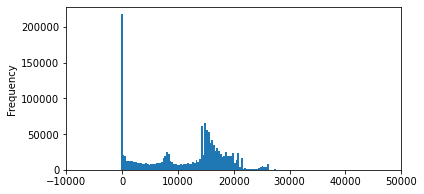

In [19]:
plt.figure(figsize=(6,3))
plt.xlim(-10000,50000)
df['health'].plot.hist(bins=1000);

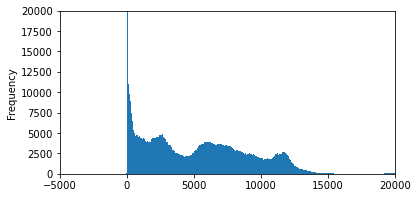

In [20]:
plt.figure(figsize=(6,3))
plt.xlim(-5000,20000)
plt.ylim(0,20000)
df['other_benefits'].plot.hist(bins=1000);

In [21]:
df['job_title'] = df['job_title'].fillna("Not disclosed")
df['overtime'] = df['overtime'].fillna(0)
df['irregular_cash'] = df['irregular_cash'].fillna(0)
df['health'] = df['health'].fillna(0)
df['other_benefits'] = df['other_benefits'].fillna(0)

df['base_salary'] = df['base_salary'].fillna((df['total_cash'] - df['overtime'] - df['irregular_cash']))

df.isna().sum()

year                  0
department            0
job_title             0
base_salary           0
overtime              0
irregular_cash        0
total_cash            0
retirement            0
health                0
other_benefits        0
total_benefits        0
total_compensation    0
city_id               0
annual_average_cpi    0
inflation_rate        0
dtype: int64

In [22]:
len(df)

1466589

In [23]:
df = df[df['base_salary'] >= 0]

In [24]:
df = df[df['total_compensation'] >= 0]

In [25]:
len(df)

1465857

### Some visuals

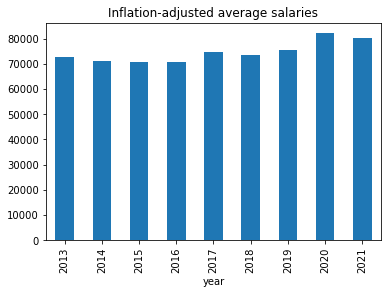

In [26]:
df.groupby('year')['base_salary'].mean().plot.bar()
plt.title("Inflation-adjusted average salaries");

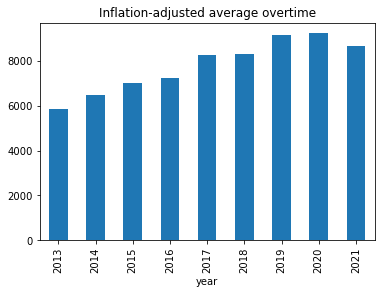

In [27]:
df.groupby('year')['overtime'].mean().plot.bar()
plt.title("Inflation-adjusted average overtime");

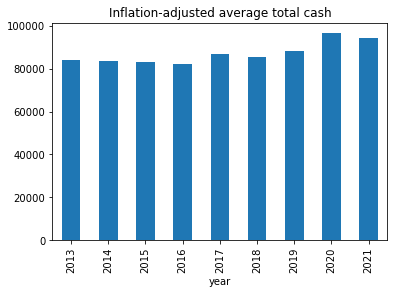

In [28]:
df.groupby('year')['total_cash'].mean().plot.bar()
plt.title("Inflation-adjusted average total cash");

<AxesSubplot:xlabel='city_id,year'>

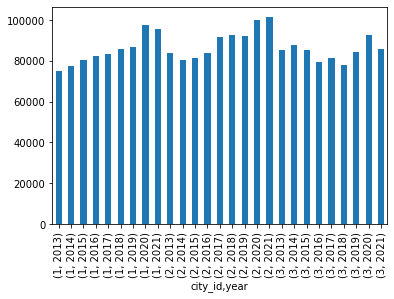

In [29]:
df.groupby(['city_id','year'])['total_cash'].mean().plot.bar()

In [30]:
df = pd.get_dummies(df,columns=['department'],drop_first=True)

In [31]:
df_copy=df.drop(['job_title', 'total_cash', 'retirement', 'health', 'other_benefits','total_compensation','inflation_rate'], axis=1)
df_copy.head()

,year,base_salary,overtime,irregular_cash,total_benefits,city_id,annual_average_cpi,department_Emergency Management,"department_Energy, Env, Economy",department_Finance,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works
0,2020,5505.341963,0.000000,145.887635,438.626275,2,258.8,0,0,0,0,0,0,0,1,0,0,0
1,2020,8062.134815,2007.263910,0.000000,781.543895,2,258.8,0,0,0,0,0,0,0,0,0,0,0
2,2020,2742.618431,974.364374,0.000000,288.497720,2,258.8,0,0,0,0,0,0,0,0,0,0,0
3,2020,1958.802241,619.090495,0.000000,200.077164,2,258.8,0,0,0,0,0,0,0,0,0,0,0
4,2020,166298.647372,0.000000,5944.554637,63125.282380,2,258.8,0,0,0,0,0,0,0,0,0,0,1


In [32]:
# Define Predictor and Outcome
X = df_copy.drop('total_benefits',axis=1)
y = df_copy['total_benefits']

In [33]:
# Split the Data - 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=12345)

In [34]:
# Scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [35]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)
# Prediction
y_pred_lin = lin_reg.predict(X_test_scaled)
R2_lin = metrics.r2_score(y_test, y_pred_lin).round(4)
mae_lin = metrics.mean_absolute_error(y_test, y_pred_lin).round(4)
mse_lin = metrics.mean_squared_error(y_test, y_pred_lin).round(4)
rmse_lin = np.sqrt(mse_lin).round(4)
# Printing the metrics
# print('Linear Regression goodness of fit: ', lin_reg.score(X_test_scaled, y_test).round(4))
print('R2 square:', R2_lin)
print('MAE: ', mae_lin)
print('MSE: ', mse_lin)
print('RMSE: ', rmse_lin)

Linear Regression Accuracy:  0.7817
R2 square: 0.7817
MAE:  7720.4161
MSE:  127212209.5952
RMSE:  11278.839


Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted')

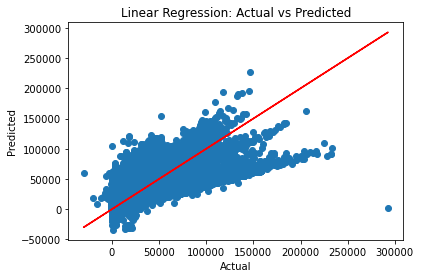

In [36]:
plt.scatter(y_test,y_pred_lin)
plt.plot(y_test,y_test, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')

In [37]:
# Decision Tree
dt_regressor = DecisionTreeRegressor(random_state = 12345)
dt_regressor.fit(X_train_scaled, y_train)
# Prediction
y_pred_dt = dt_regressor.predict(X_test_scaled)
R2_dt = metrics.r2_score(y_test, y_pred_dt).round(4)
mae_dt = metrics.mean_absolute_error(y_test, y_pred_dt).round(4)
mse_dt = metrics.mean_squared_error(y_test, y_pred_dt).round(4)
rmse_dt = np.sqrt(mse_dt).round(4)
# Printing the metrics
# print('Decision Tree Regression goodness of fit: ', dt_regressor.score(X_test_scaled,y_test).round(4))
print('R2 square:', R2_dt)
print('MAE: ', mae_dt)
print('MSE: ', mse_dt)
print('RMSE: ', rmse_dt)

Decision Tree Regression Accuracy:  0.8814
R2 square: 0.8814
MAE:  4271.9505
MSE:  69110903.0235
RMSE:  8313.2968


Text(0.5, 1.0, 'Decision Tree Regressor: Actual vs Predicted')

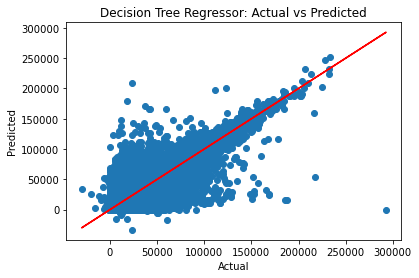

In [38]:
plt.scatter(y_test,y_pred_dt)
plt.plot(y_test,y_test, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree Regressor: Actual vs Predicted')

In [87]:
# Random Forest Regression
rf_regressor = RandomForestRegressor(n_estimators = 300 , random_state = 12345)
rf_regressor.fit(X_train_scaled, y_train)
# Prediction
y_pred_rf = rf_regressor.predict(X_test_scaled)
R2_rf = metrics.r2_score(y_test, y_pred_rf).round(4)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf).round(4)
mse_rf = metrics.mean_squared_error(y_test, y_pred_rf).round(4)
rmse_rf = np.sqrt(mse_rf).round(4)
# Printing the metrics
# print('Random Forest Regression goodness of fit: ', rf_regressor.score(X_test_scaled,y_test).round(4))
print('R2 square:', R2_rf)
print('MAE: ', mae_rf)
print('MSE: ', mse_rf)
print('RMSE: ', rmse_rf)

Random Forest Regression Accuracy:  0.935
R2 square: 0.935
MAE:  3410.7898
MSE:  37859078.3365
RMSE:  6152.9731


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

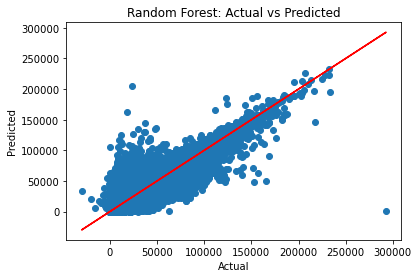

In [88]:
plt.scatter(y_test,y_pred_rf)
plt.plot(y_test,y_test, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')

In [89]:
# Neural Network
mlp_reg = MLPRegressor(hidden_layer_sizes =(150,100,50), max_iter = 300,activation = 'relu',
solver = 'adam', random_state = 12345)
mlp_reg.fit(X_train_scaled, y_train)
# Prediction
y_pred_nn = mlp_reg.predict(X_test_scaled)
R2_nn = metrics.r2_score(y_test, y_pred_nn).round(4)
mae_nn = metrics.mean_absolute_error(y_test, y_pred_nn).round(4)
mse_nn = metrics.mean_squared_error(y_test, y_pred_nn).round(4)
rmse_nn = np.sqrt(mse_nn).round(4)
# Printing the metrics
# print('Neural Network Regression goodness of fit: ', mlp_reg.score(X_test_scaled,y_test).round(4))
print('R2 square:', R2_nn)
print('MAE: ', mae_nn)
print('MSE: ', mse_nn)
print('RMSE: ', rmse_nn)

Neural Network Regression Accuracy:  0.93
R2 square: 0.93
MAE:  3712.015
MSE:  40811691.0904
RMSE:  6388.4029


Text(0.5, 1.0, 'Neural Network: Actual vs Predicted')

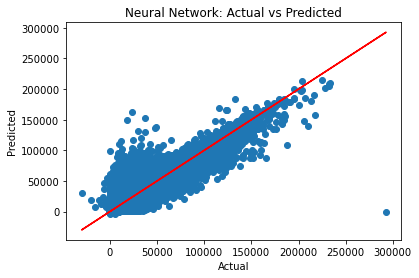

In [90]:
plt.scatter(y_test,y_pred_nn)
plt.plot(y_test,y_test, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Neural Network: Actual vs Predicted')